# Monthly Climatology of EKE in NATL
$\frac{1}{2}(U^{'2} + V^{'2})$

CESM

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
#options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.802690356e914ae19989977eb84492a2/status,


In [17]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools
import gsw

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'KMT', 'TAREA',
                                                         'HUS', 'HTE','HTN', 'HUW', 'time']])

/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/tmp/ipykernel_1169/604604071.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'KMT', 'TAREA',


## MASK

In [5]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [6]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [7]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

In [8]:
selection = dict(nlon=slice(100,1300), nlat=slice(1200, None))

### Significant difference in 1 & 2

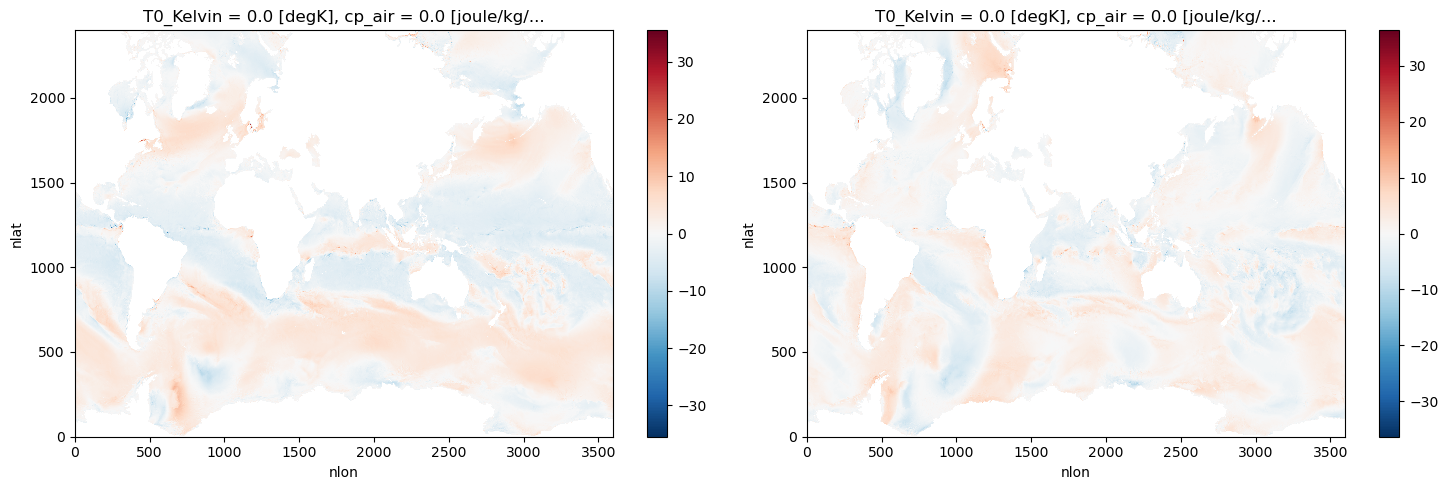

In [29]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,5))
(cesm.U1_1[0] - cesm.U2_2[0]).plot(ax=ax0)
(cesm.V1_1[0] - cesm.V2_2[0]).plot(ax=ax1)
plt.tight_layout();

## Rho contour

In [9]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

In [10]:
selection = dict(nlon=slice(100,1300), nlat=slice(1200, None))
rho_gb = rho.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

## 1_1

In [11]:
up1 = (cesm.U1_1.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.U1_1.where(atl_mask).isel(**selection).groupby('time.month'))
vp1 = (cesm.V1_1.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.V1_1.where(atl_mask).isel(**selection).groupby('time.month'))

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [12]:
#convert cm/s to m/s
up = up1*1e-2
vp = vp1*1e-2

In [13]:
eke1 = 0.5 * (up**2 + vp**2)

In [14]:
eke1_clim = eke1.groupby('time.month').mean('time')

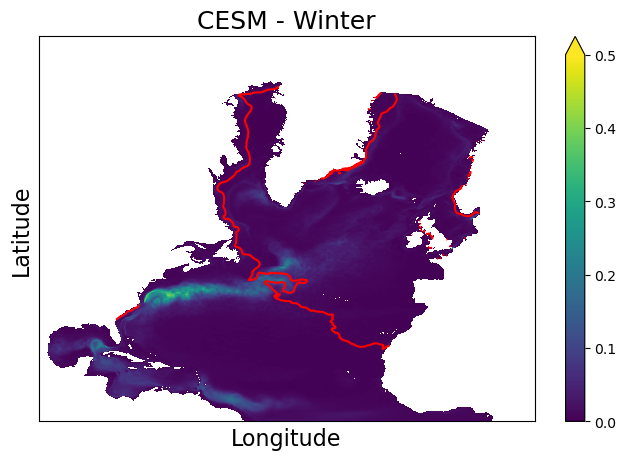

In [15]:
fig, ax0 = plt.subplots(figsize=(8,5))

eke1_clim.sel(month=3).plot(ax=ax0, vmin=0, vmax=0.5, rasterized=True)
rho_gb.sel(month=3).plot.contour(colors='r', levels=[rho_bins[113]], ax=ax0,) 
                                 #cbar_kwargs={'shrink':0.8, 'label':r'[m^2 s$^{-2}$]'})
plt.tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('CESM - Winter', fontsize=18)
plt.savefig('EKE-CESM-winter.pdf');

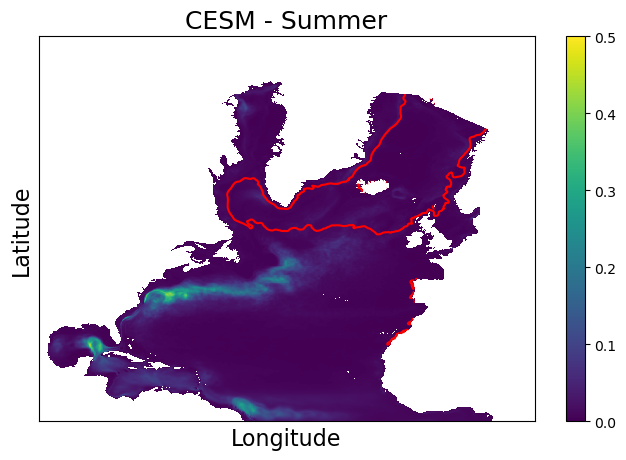

In [16]:
fig, ax0 = plt.subplots(figsize=(8,5))

eke1_clim.sel(month=8).plot(ax=ax0, vmin=0, vmax=0.5, rasterized=True)
rho_gb.sel(month=8).plot.contour(colors='r', levels=[rho_bins[113]], ax=ax0,) 
                                 #cbar_kwargs={'shrink':0.8, 'label':r'[m^2 s$^{-2}$]'})
plt.tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('CESM - Summer', fontsize=18)
plt.savefig('EKE-CESM-summer.pdf');

## 2_2

In [17]:
up2 = (cesm.U2_2.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.U2_2.where(atl_mask).isel(**selection).groupby('time.month'))
vp2 = (cesm.V2_2.where(atl_mask).isel(**selection).groupby('time.month').mean('time') - 
       cesm.V2_2.where(atl_mask).isel(**selection).groupby('time.month'))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [18]:
eke2 = 0.5 * (up2**2 + vp2**2)

In [19]:
eke2_clim = eke2.groupby('time.month').mean('time')

In [20]:
eke2_clim

<xarray.DataArray (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float32, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/22)
    ANGLE        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET       (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU          (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...           ...
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    UAREA        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULAT         (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ULONG        (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon

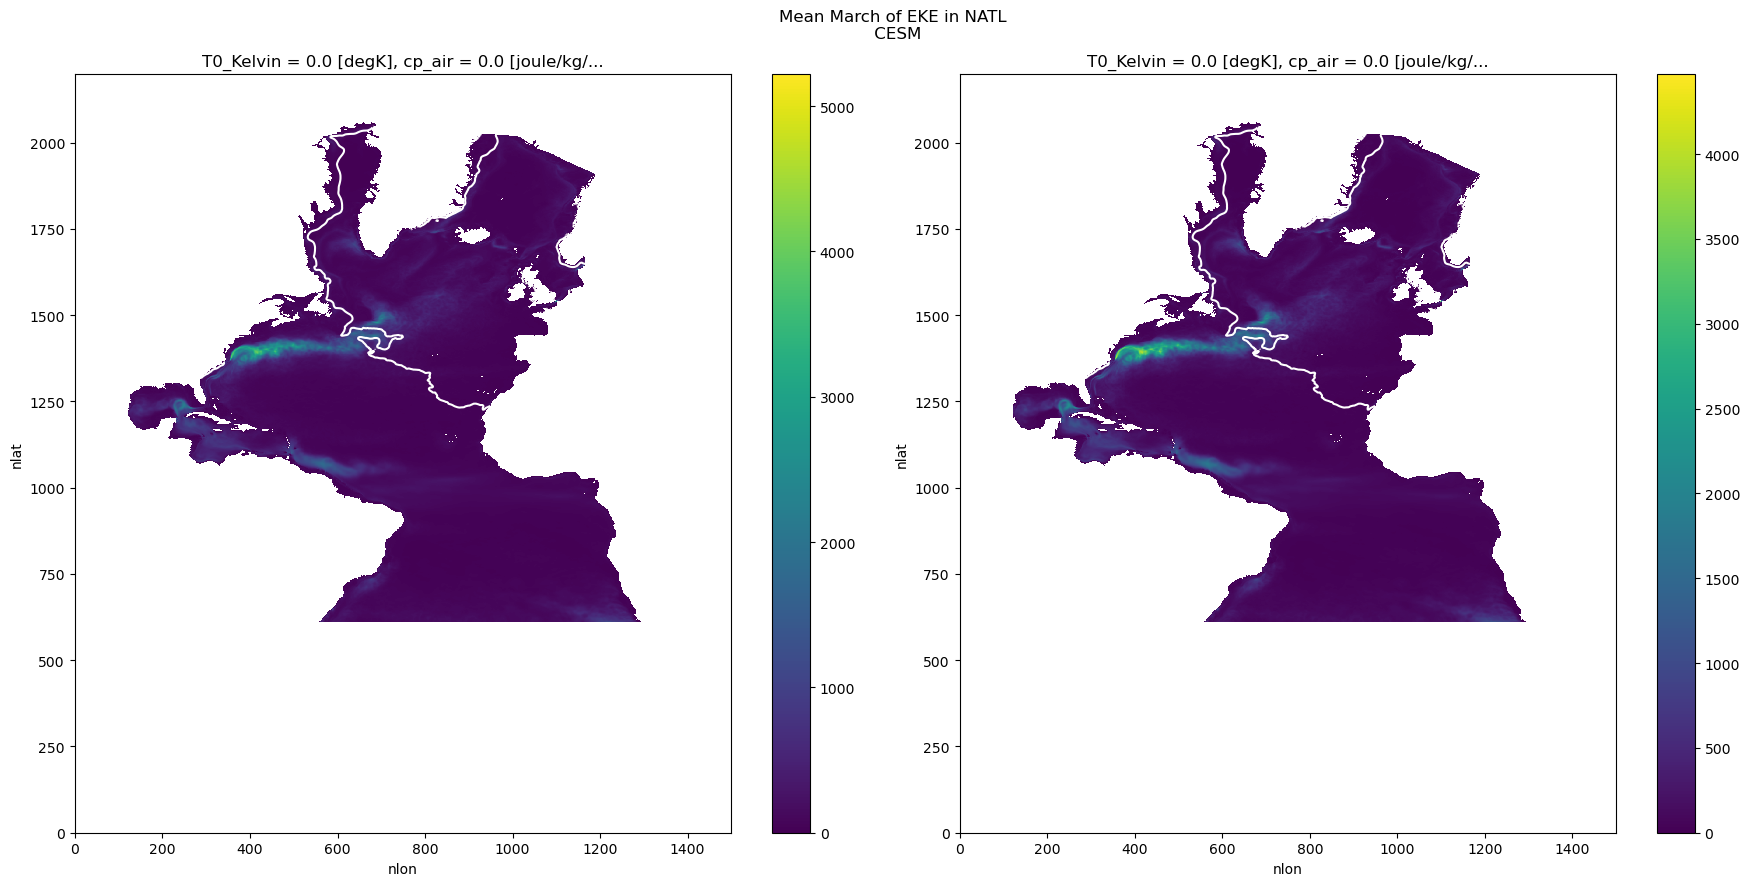

In [21]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(18,9))

eke1_clim.sel(month=3).plot(ax=ax0)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax0)

c = eke2_clim.sel(month=3).plot(ax=ax1)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[113]], ax=ax1)

#plt.colorbar(c, ax=ax1, label=r'[cm^2 s$^{-1}$]')
plt.suptitle('Mean March of EKE in NATL \n CESM')
plt.tight_layout();

# RMS
the square root of the mean of the squared values of elements of y in $y = m(x) + b$

In [13]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [14]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_bih']*ds['drhodt']).rename('sst'),
                      (ds['SSS_bih']*ds['drhods']).rename('sss'),
                       ds['rho_bih'].rename('rho'),
                       ds['cabbeling']])
    return newds

In [15]:
tend = new_ds(tendencies)

In [16]:
tend

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 14965)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [31]:
#adding lon/lat coords to rho_gb so contour can show in plots
rho_gb_ac = rho_gb.assign_coords({'nlon':tend.nlon.isel(nlon=slice(100,1300)),
                      'nlat':tend.nlat.isel(nlat=slice(1200, None))})
rho_gb_ac

<xarray.DataArray 'rho' (month: 12, nlat: 1200, nlon: 1200)>
dask.array<transpose, shape=(12, 1200, 1200), dtype=float64, chunksize=(1, 1200, 1200), chunktype=numpy.ndarray>
Coordinates: (12/54)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    ...                  ...
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * nlon                (nlon) int64 100 101 102 103 104 ... 1296 1297 1298 1299
  * nlat                (nlat) int64 1200 1201 1202 1203 ... 2396 2397 2398 2399
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

In [17]:
def rms(da):
    rms = ((da**2).groupby('time.month').mean('time'))**0.5
    return rms

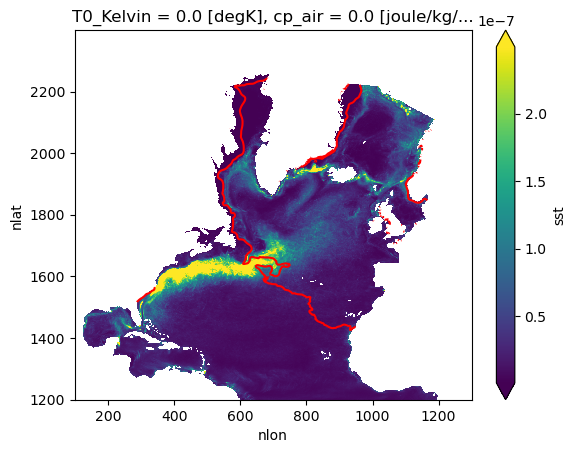

In [32]:
rms(tend.sst).where(atl_mask).isel(**selection).sel(month=3).plot(robust=True)
rho_gb_ac.sel(month=3).plot.contour(colors='r', levels=[rho_bins[113]])

In [40]:
def plot_contours_tend_terms(axis, tend_term, month_name):
    """Plot surface density contours and tendency terms"""
    selection = dict(nlon=slice(100,1300), nlat=slice(1200, None))
    kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}
    
    rms(tend_term).where(atl_mask).isel(**selection).sel(month=month_name).plot(robust=True, ax=axis, 
                                                                                vmin=0, vmax=3.5e-7, cbar_kwargs=kwargs)
    rho_gb_ac.sel(month=month_name).plot.contour(colors='r', levels=[rho_bins[113]], ax=axis)
    
    axis.tick_params(left = False, labelleft=False, bottom = False, labelbottom=False)
    axis.set_ylabel('Latitude')
    axis.set_xlabel('Longitude')

Task exception was never retrieved
future: <Task finished name='Task-4679' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit


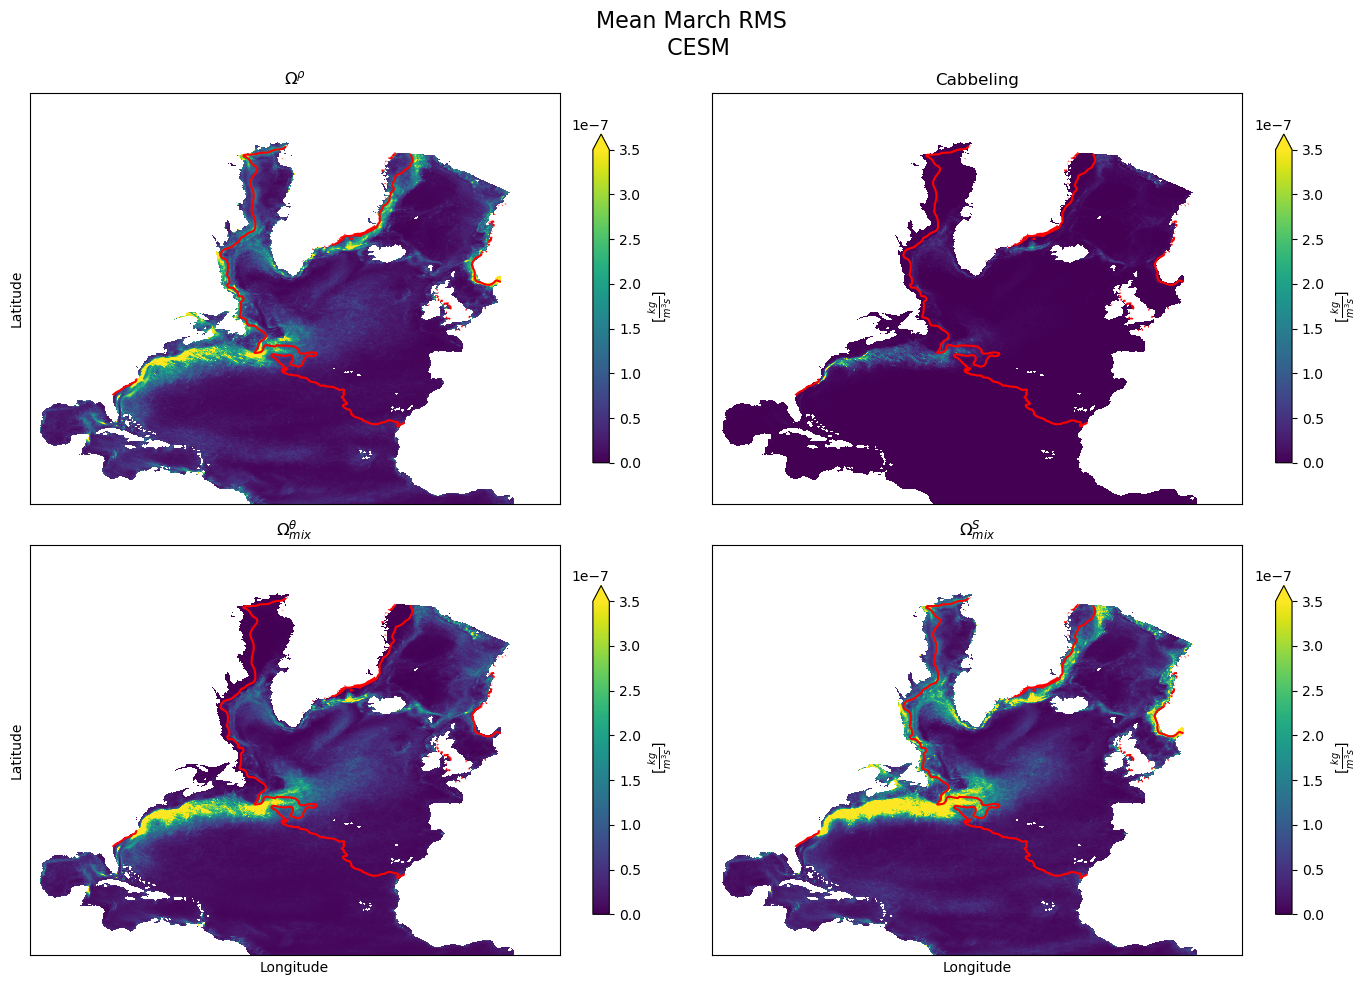

In [41]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(14,10))

plot_contours_tend_terms(ax[0,0], tend.rho, 3)
ax[0,0].set_title(r'$\Omega^{\rho}$')
ax[0,0].set_xlabel('')

plot_contours_tend_terms(ax[0,1], tend.cabbeling, 3)
ax[0,1].set_title('Cabbeling')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

plot_contours_tend_terms(ax[1,0], tend.sst, 3)
ax[1,0].set_title(r'$\Omega^{\theta}_{mix}$')

plot_contours_tend_terms(ax[1,1], tend.sss, 3)
ax[1,1].set_title(r'$\Omega^S_{mix}$')
ax[1,1].set_ylabel('')

plt.suptitle('Mean March RMS \n CESM', fontsize=16)
plt.tight_layout();

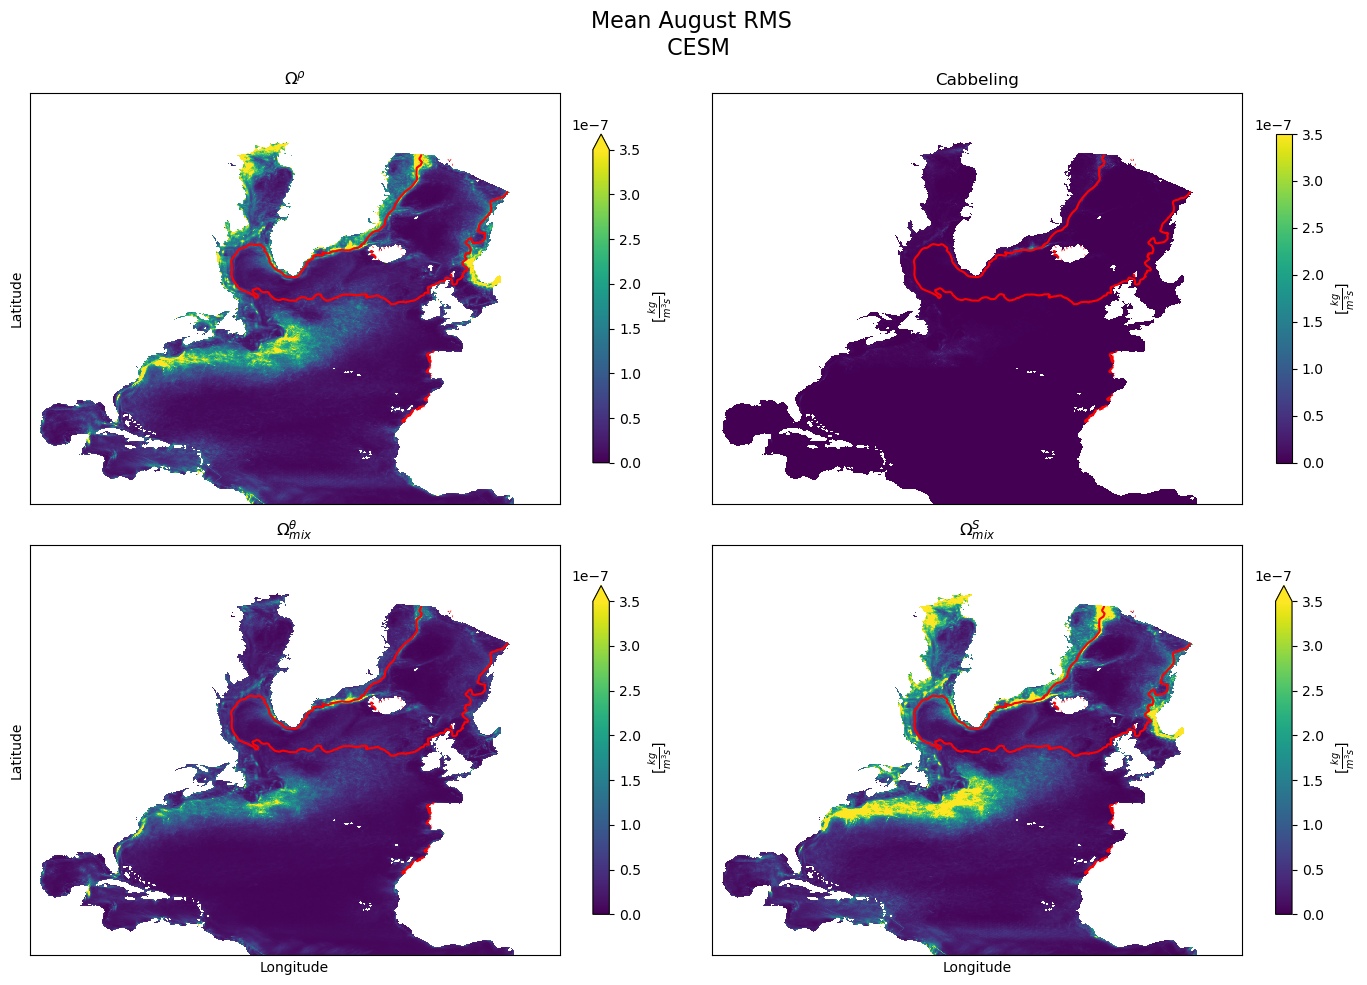

In [42]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(14,10))

plot_contours_tend_terms(ax[0,0], tend.rho, 8)
ax[0,0].set_title(r'$\Omega^{\rho}$')
ax[0,0].set_xlabel('')

plot_contours_tend_terms(ax[0,1], tend.cabbeling, 8)
ax[0,1].set_title('Cabbeling')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

plot_contours_tend_terms(ax[1,0], tend.sst, 8)
ax[1,0].set_title(r'$\Omega^{\theta}_{mix}$')

plot_contours_tend_terms(ax[1,1], tend.sss, 8)
ax[1,1].set_title(r'$\Omega^S_{mix}$')
ax[1,1].set_ylabel('')

plt.suptitle('Mean August RMS \n CESM', fontsize=16)
plt.tight_layout();

In [54]:
client.close()
cluster.close()